In [2]:
#!source ../activate_conda.sh
import processor.fake_rate_measurement as fr
import matplotlib.pyplot as plt
import awkward as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np
from yahist import Hist1D, Hist2D

# this is all very bad practice
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *

In [3]:
from klepto.archives import dir_archive
from processor.default_accumulators import desired_output, add_processes_to_output, dataset_axis, pt_axis, eta_axis

from Tools.helpers import get_samples
from Tools.config_helpers import redirector_ucsd, redirector_fnal
from Tools.nano_mapping import make_fileset

overwrite = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'nano_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018

samples = get_samples()

fileset = make_fileset(['QCD'], samples, redirector=redirector_ucsd, small=True)

add_processes_to_output(fileset, desired_output)
pt_axis_mu = hist.Bin("pt", r"$p_{T}$ (GeV)", [10.,15.,20.,32., 45., 65., 100.])
eta_axis_mu =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.2, 2.5])
pt_axis_e = hist.Bin("pt", r"$p_{T}$ (GeV)", [0, 25., 35., 45., 65., 100])
eta_axis_e =  hist.Bin("eta", r"$p_{T}$ (GeV)", [0, 1.479, 2.5])

desired_output.update({
    "single_mu_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_mu": hist.Hist("Counts", dataset_axis, pt_axis_mu, eta_axis_mu),
    "single_e_fakeable": hist.Hist("Counts", dataset_axis, pt_axis_e, eta_axis_e),
    "single_e": hist.Hist("Counts", dataset_axis, pt_axis_e, eta_axis_e)
})

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
    "skipbadfiles": True,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")

    output = processor.run_uproot_job(
        fileset,
        "Events",
        fr.nano_analysis(year=year, variations=[], accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )

    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()


I'm running now


Preprocessing:   0%|          | 0/21 [00:00<?, ?file/s]

Processing:   0%|          | 0/54 [00:00<?, ?chunk/s]

In [4]:
fakeable_mu_hist = output["single_mu_fakeable"]
tight_mu_hist = output["single_mu"]
fakeable_e_hist = output["single_e_fakeable"]
tight_e_hist = output["single_e"]

In [5]:
# import uproot
# tree = uproot.open('root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-15to20_EMEnriched_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/120000/DBBFA116-54FD-1F49-99EA-A95187A4D14C.root')['Events']
# tree.arrays(['MET_pt'])

<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='$p_{T}$ (GeV)'>

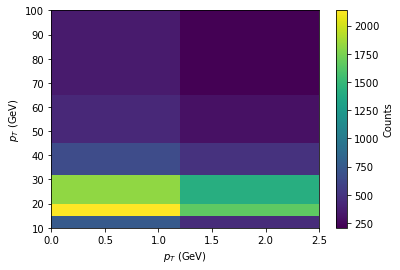

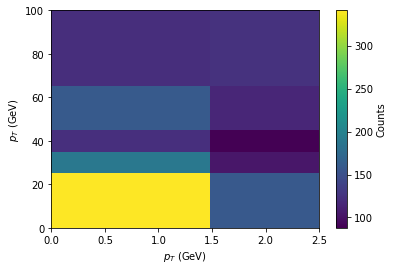

In [6]:
# pt_bins = hist.Bin("pt", r'$P_{T}\ GeV$', [0, 25., 35., 45., 65., 120.])#[[0, 25.],[25., 35.], [35., 45.], [45., 65.], [65., 120.]])
# eta_bins_mu = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.2, 1.2,  2.5])
# eta_bins_e = hist.Bin('eta', r'$eta\ (GeV)$',[-2.5, -1.5, 1.5, 2.5])
rebinned_fakeable_mu_hist = fakeable_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_fakeable_e_hist = fakeable_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)
hist.plot2d(rebinned_fakeable_mu_hist.sum("dataset"), xaxis="eta")
hist.plot2d(rebinned_fakeable_e_hist.sum("dataset"), xaxis="eta")

<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='$p_{T}$ (GeV)'>

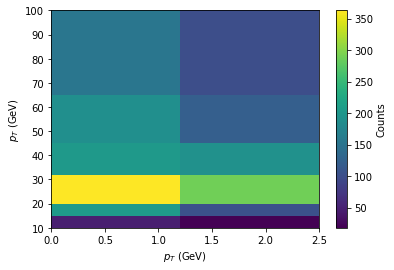

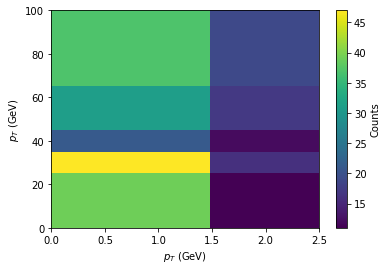

In [7]:
rebinned_tight_mu_hist = tight_mu_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_mu)
rebinned_tight_e_hist = tight_e_hist#.rebin('pt', pt_bins).rebin('eta', eta_bins_e)
hist.plot2d(rebinned_tight_mu_hist.sum("dataset"), xaxis="eta")
hist.plot2d(rebinned_tight_e_hist.sum("dataset"), xaxis="eta")

In [8]:
# num = Hist2D.from_bincounts(b.sum('dataset').values()[()].T, (b.axis('pt').edges(), b.axis('eta').edges()))
# denom = Hist2D.from_bincounts((a+b).sum('dataset').values()[()].T, ((a+b).axis('pt').edges(), (a+b).axis('eta').edges()))
num_mu = (rebinned_tight_mu_hist).sum('dataset')
denom_mu = (rebinned_fakeable_mu_hist+rebinned_tight_mu_hist).sum('dataset')

num_e = (rebinned_tight_e_hist).sum('dataset')
denom_e = (rebinned_fakeable_e_hist+rebinned_tight_e_hist).sum('dataset')

In [9]:
def divide_2D_hist(x, y):
    x_axis_0 = x.axes()[0].name
    x_axis_1 = x.axes()[1].name
    y_axis_0 = y.axes()[0].name
    y_axis_1 = y.axes()[1].name
    yahist_x = Hist2D.from_bincounts(x.values()[()].T, (x.axis(x_axis_0).edges(), x.axis(x_axis_1).edges()))
    yahist_y = Hist2D.from_bincounts(y.values()[()].T, (y.axis(y_axis_0).edges(), y.axis(y_axis_1).edges()))
    return yahist_x.divide(yahist_y)

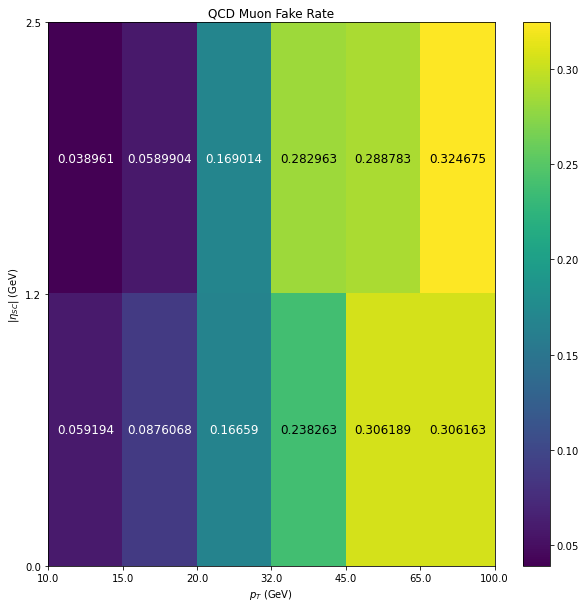

In [10]:
plt.figure("QCD_mu_fake_rate", figsize = (10,10))
divide_2D_hist(num_mu, denom_mu).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'$p_T$ (GeV)')
plt.ylabel(r'$\left|\eta_{SC}\right|$ (GeV)')
plt.title('QCD Muon Fake Rate')
plt.show()

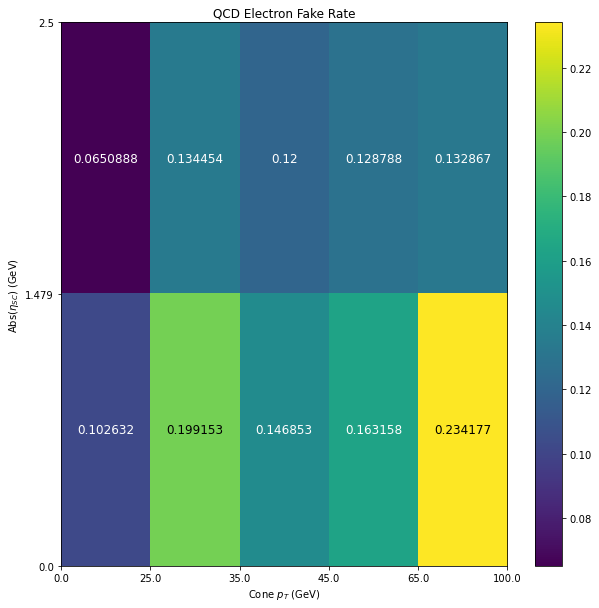

In [11]:
plt.figure("QCD_e_fake_rate", figsize = (10,10))
divide_2D_hist(num_e, denom_e).plot(show_counts=True, equidistant='xy')
#plt.xticks(np.arange(0, 130, 10))
plt.xlabel(r'Cone $p_T$ (GeV)')
plt.ylabel(r'Abs($\eta_{SC}$) (GeV)')
plt.title('QCD Electron Fake Rate')
plt.show()

In [11]:
x1 = a.sum('dataset')
x1_axis_0 = x1.axes()[0].name
x1_axis_1 = x1.axes()[1].name
x1_y = Hist2D.from_bincounts(x1.values()[()].T, (x1.axis(x1_axis_0).edges(), x1.axis(x1_axis_1).edges()))
hist.plot2d(x1, xaxis = x1.axes()[0].name)
plt.figure('test2', figsize = (7,7))
x1_y.plot(show_counts=True)
plt.draw()

NameError: name 'a' is not defined